## Load Data

In [22]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# read the dataset
data_df = pd.read_csv('data/driving_log.csv', header=None)

In [24]:
# get the center, left and right as X data and the steering angle as y data
X = data_df[[0,1,2]].values
y = data_df[3].values

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [26]:
print('Train Length:',len(X_train))
print('Val Length:',len(X_val))

Train Length: 12567
Val Length: 6190


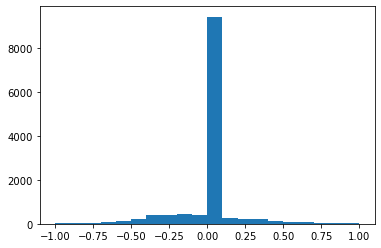

In [27]:
# steering angle histogram
plt.hist(y_train, bins=20)
plt.show()

## Data Preprocessing and Augmentation

* augmentation
    * choose center | left | right
    * flip
    * brightness
* preprocess
* batch generator

In [28]:
def choose_image(image_paths, steering_angle):
    '''Choose center | left | right and adjust the steering angle accordingly'''
    
    choice = np.random.choice(3)
    
    if choice == 0: # left
        return cv2.imread(image_paths[1].strip()), steering_angle + 0.2
    
    elif choice == 1: # right
        return cv2.imread(image_paths[2].strip()), steering_angle - 0.2
    
    return cv2.imread(image_paths[0].strip()), steering_angle # center

In [29]:
def random_flip(image, steering_angle):
    '''Randomly flip the image horizontally and adjust steering angle'''
    
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [30]:
def random_brightness(image):
    '''Randomly increase or decrease brightness'''
    
    choice = np.random.choice(2)
    
    if choice == 1:
        return image + np.random.randint(1,20)
    
    return image - np.random.randint(0,30)

In [31]:
def augmentation(image_paths, steering_angle):
    '''Generate an augmented image'''
    
    image, steering_angle = choose_image(image_paths, steering_angle)
    
    image, steering_angle = random_flip(image, steering_angle)
    image = random_brightness(image)
    
    return image, steering_angle

In [32]:
def preprocess_image(img):
    '''Preprocess an image by cropping and resizing'''
    img = img[60:-25,:]
    img = cv2.resize(img, (200, 66))
    return img

In [33]:
def batch_generator(X_data, y_data, batch_size, is_training=True):
    '''Generate Training Data'''
    
    images = np.empty([batch_size, 66, 200, 3])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for idx in np.random.permutation(X_data.shape[0]):
            image_paths = X_data[idx]
            steering_angle = y_data[idx]
            
            # randomly decide to augment or not
            if is_training and np.random.rand() < 0.5:
                image, steering_angle = augmentation(image_paths, steering_angle)
            else:
                image = cv2.imread(image_paths[0])
            
            images[i] = preprocess_image(image)
            steers[i] = steering_angle
            
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [34]:
def display_image(img):
    cv2.imshow('img', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [39]:
# # Display an augmented image
# # itest = cv2.imread(X[432][0].strip())
# itest, _ = augmentation(X[432], y[432])
# itest = preprocess_image(itest)
# display_image(itest)

## Building the Model

In [15]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Convolution2D
from tensorflow.keras.models import Sequential

In [16]:
model = Sequential(name='NvidiaModel')

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66,200,3)))      

# 24 filters, kernel size = 5x5, stride = 2x2
model.add(Convolution2D(24,5,2, activation='elu'))

# 36 filters, kernel size = 5x5, stride = 2x2
model.add(Convolution2D(36,5,2, activation='elu'))

# 48 filters, kernel size = 5x5, stride = 2x2
model.add(Convolution2D(48,5,2, activation='elu'))

# 64 filters, kernel size = 3x3, stride = 1x1
model.add(Convolution2D(64,3, activation='elu'))

# 64 filters, kernel size = 3x3, stride = 1x1
model.add(Convolution2D(64,3, activation='elu'))

model.add(Flatten())

model.add(Dense(100, activation='elu'))

model.add(Dropout(0.25))

model.add(Dense(50, activation='elu'))

model.add(Dense(10, activation='elu'))

model.add(Dense(1))

model.summary()

Model: "NvidiaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              

## Train Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [18]:
checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_loss:.3f}.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False)

In [19]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5
STEPS_PER_EPOCH = 5000
VALIDATION_STEPS = 1000
LEARNING_RATE = 0.0001

In [20]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=LEARNING_RATE))

In [21]:
model.fit_generator(batch_generator(X_train, y_train, BATCH_SIZE), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint], 
                    validation_data=batch_generator(X_val, y_val, BATCH_SIZE, is_training=False), 
                    validation_steps=VALIDATION_STEPS)

Epoch 1/5
4999/5000 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 00001: saving model to model-01-0.028.h5
5000/5000 [==============================] - 717s 143ms/step - loss: 0.0378 - val_loss: 0.0282
Epoch 2/5
4999/5000 [============================>.] - ETA: 0s - loss: 0.0344
Epoch 00002: saving model to model-02-0.028.h5
5000/5000 [==============================] - 676s 135ms/step - loss: 0.0344 - val_loss: 0.0277
Epoch 3/5
4999/5000 [============================>.] - ETA: 0s - loss: 0.0336
Epoch 00003: saving model to model-03-0.029.h5
5000/5000 [==============================] - 644s 129ms/step - loss: 0.0336 - val_loss: 0.0290
Epoch 4/5
4999/5000 [============================>.] - ETA: 0s - loss: 0.0335
Epoch 00004: saving model to model-04-0.028.h5
5000/5000 [==============================] - 479s 96ms/step - loss: 0.0335 - val_loss: 0.0279
Epoch 5/5
4999/5000 [============================>.] - ETA: 0s - loss: 0.0322
Epoch 00005: saving model to model-05-0.029